<a href="https://colab.research.google.com/github/cars1015/100knock-data_analytics/blob/main/%E7%AC%AC7%E7%AB%A0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
import os
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
dir='/content/drive/My Drive/データ分析100本ノック/data'
data_dir=os.path.join(dir+'/100knock-data_analytics/7')
os.chdir(data_dir)

ノック61

In [38]:
!pip install pulp
!pip install ortoolpy

In [39]:
import numpy as np
import pandas as pd
from itertools import product
from pulp import LpVariable, lpSum, value
from ortoolpy import model_min,addvars,addvals

#データ読み込み
df_tc=pd.read_csv("trans_cost.csv",index_col="工場")
df_demand=pd.read_csv("demand.csv")
df_supply=pd.read_csv("supply.csv")

#初期設定
np.random.seed(1)
nw=len(df_tc.index)
nf=len(df_tc.columns)
pr=list(product(range(nw),range(nf)))

#数理モデル作成
m1=model_min()
v1={(i,j):LpVariable('v%d_%d'%(i,j),lowBound=0) for i,j in pr}

m1+=lpSum(df_tc.iloc[i][j]*v1[i,j] for i,j in pr)
for i in range(nw):
  m1+=lpSum(v1[i,j] for j in range(nf))<=df_supply.iloc[0][i]
for j in range(nf):
  m1+=lpSum(v1[i,j] for i in range(nw))>=df_demand.iloc[0][j]
m1.solve()

#輸送コスト計算#
df_tr_sol=df_tc.copy()
total_cost=0
for k,x in v1.items():
  i,j=k[0],k[1]
  df_tr_sol.iloc[i][j]=value(x)
  total_cost+=df_tc.iloc[i][j]*value(x)
print(df_tr_sol)
print("総輸送コスト：",total_cost)

    F1  F2  F3  F4
工場                
W1  28   7   0   0
W2   0   0  31   5
W3   0  22   0  20
総輸送コスト： 1296.0


ノック62

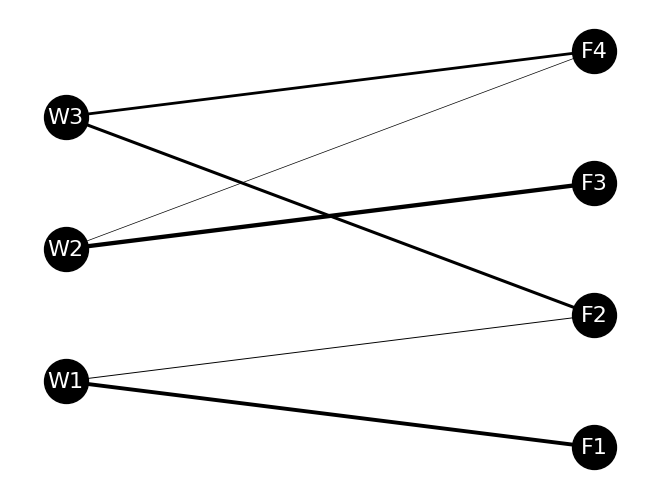

In [40]:
import matplotlib.pyplot as plt
import networkx as nx

df_tr=df_tr_sol.copy()
df_pos=pd.read_csv("trans_route_pos.csv")

#グラフオブジェクトの作成
G=nx.Graph()

#頂点の設定
for i in range(len(df_pos.columns)):
  G.add_node(df_pos.columns[i])

num_pre=0
edges_weight=[]
size=0.1
for i in range(df_pos.shape[1]):
  for j in range(len(df_pos.columns)):
    if not(i==j):
      G.add_edge(df_pos.columns[i],df_pos.columns[j])
      if num_pre<len(G.edges):
        num_pre=len(G.edges)
        weight=0
        if(df_pos.columns[i] in df_tr.columns) and (df_pos.columns[j] in df_tr.index):
          if df_tr[df_pos.columns[i]][df_pos.columns[j]]:
            weight=df_tr[df_pos.columns[i]][df_pos.columns[j]]*size
        elif (df_pos.columns[j] in df_tr.columns) and (df_pos.columns[i] in df_tr.index):
          if df_tr[df_pos.columns[j]][df_pos.columns[i]]:
            weight=df_tr[df_pos.columns[j]][df_pos.columns[i]]*size
        edges_weight.append(weight)
#座標の設定
pos={}
for i in range(len(df_pos.columns)):
  node=df_pos.columns[i]
  pos[node]=(df_pos[node][0],df_pos[node][1])

#描画
nx.draw(G,pos,with_labels=True,font_size=16,node_size=1000,node_color="k",font_color="w",width=edges_weight)
plt.show()

ノック63

In [41]:
df_demand=pd.read_csv("demand.csv")
df_supply=pd.read_csv("supply.csv")

#制約条件計算
#需要側
def condition_demand(df_tr,df_demand):
  flag=np.zeros(df_demand.shape[1])
  for i in range(df_demand.shape[1]):
    tmp_sum=sum(df_tr[df_demand.columns[i]])
    if tmp_sum>=df_demand.iloc[0][i]:
      flag[i]=1
  return flag

#供給側
def condition_supply(df_tr,df_supply):
  flag=np.zeros(df_supply.shape[1])
  for i in range(df_supply.shape[1]):
    temp_sum=sum(df_tr.loc[df_supply.columns[i]])
    if temp_sum<=df_supply.iloc[0][i]:
      flag[i]=1
  return flag

print("需要条件計算結果"+str(condition_demand(df_tr_sol,df_demand)))
print("供給条件計算結果"+str(condition_supply(df_tr_sol,df_supply)))


需要条件計算結果[1. 1. 1. 1.]
供給条件計算結果[1. 1. 1.]


ノック64

In [42]:
df_material=pd.read_csv("product_plan_material.csv",index_col="製品")
df_profit=pd.read_csv("product_plan_profit.csv",index_col="製品")
print(df_profit)
df_stock=pd.read_csv("product_plan_stock.csv",index_col="項目")
print(df_stock)
df_plan=pd.read_csv("product_plan.csv",index_col="製品")
print(df_plan)

      利益
製品      
製品1  5.0
製品2  4.0
    原料1  原料2  原料3
項目               
在庫   40   80   50
      生産量
製品       
製品1    16
製品2     0


ノック65

In [43]:
#利益計算関数
def product_plan(df_profit,df_plan):
  profit=0
  for i in range(len(df_profit.index)):
    for j in range(len(df_profit.columns)):
      profit+=df_profit.iloc[i][j]*df_plan.iloc[i][j]
  return profit

print("総利益",product_plan(df_profit,df_plan))

総利益 80.0


ノック66

In [44]:
from pulp import LpVariable,lpSum,value
from ortoolpy import model_max,addvars,addvals

df=df_material.copy()
inv=df_stock

m=model_max()
v1={(i):LpVariable("v%d"%(i),lowBound=0) for i in range(len(df_profit))}

m+=lpSum(df_profit.iloc[i]*v1[i] for i in range(len(df_profit)))
for i in range(df_material.shape[1]):
  m+= lpSum(df_material.iloc[j,i]*v1[j] for j in range(len(df_profit))) <= df_stock.iloc[:,i]
m.solve()

df_plan_sol=df_plan.copy()
for k,x in v1.items():
  df_plan_sol.iloc[k]=value(x)
print(df_plan_sol)
print("総利益",product_plan(df_profit,df_plan_sol))

      生産量
製品       
製品1    15
製品2     5
総利益 95.0


ノック67

In [45]:
def condition_stock(df_plan,df_material,df_stock):
  flag=np.zeros(len(df_material.columns))
  for i in range(len(df_material.columns)):
    temp_sum=0
    for j in range(len(df_material.index)):
      temp_sum=temp_sum+df_material.iloc[j][i]*float(df_plan.iloc[j])
      if(temp_sum<=float(df_stock.iloc[0][i])):
        flag[i]=1
      print(df_material.columns[i]+"使用料:"+str(temp_sum)+",在庫"+str(float(df_stock.iloc[0][i])))
  return flag

print("制約条件計算過程:"+str(condition_stock(df_plan_sol,df_material,df_stock)))

原料1使用料:15.0,在庫40.0
原料1使用料:25.0,在庫40.0
原料2使用料:60.0,在庫80.0
原料2使用料:80.0,在庫80.0
原料3使用料:45.0,在庫50.0
原料3使用料:50.0,在庫50.0
制約条件計算過程:[1. 1. 1.]


ノック68

In [48]:
製品=list("AB")
需要地=list("PQ")
工場=list("XY")
レーン=(2,2)

#輸送費表
tbdi=pd.DataFrame(((j,k) for j in 需要地 for k in 工場), columns=["需要地","工場"])
tbdi["輸送費"]=[1,2,3,1]
print(tbdi)

#需要表#
tbde=pd.DataFrame(((j,i) for j in 需要地 for i in 製品),columns=['需要地','製品'])
tbde['需要']=[10,10,20,20]
print(tbde)

#生産表
tbfa=pd.DataFrame(((k,l,i,0,np.inf) for k ,nl in zip(工場,レーン)for l in range(nl) for i in 製品),columns=['工場','レーン','製品','下限','上限'])
tbfa["生産費"]=[1,np.nan,np.nan,1,3,np.nan,5,3]
tbfa.dropna(inplace=True)
tbfa.loc[4,"上限"]=10
print(tbfa)

from ortoolpy import logistics_network
_,tbdi2,_=logistics_network(tbde,tbdi,tbfa)
print(tbfa)
print(tbdi2)


  需要地 工場  輸送費
0   P  X    1
1   P  Y    2
2   Q  X    3
3   Q  Y    1
  需要地 製品  需要
0   P  A  10
1   P  B  10
2   Q  A  20
3   Q  B  20
  工場  レーン 製品  下限    上限  生産費
0  X    0  A   0   inf  1.0
3  X    1  B   0   inf  1.0
4  Y    0  A   0  10.0  3.0
6  Y    1  A   0   inf  5.0
7  Y    1  B   0   inf  3.0
  工場  レーン 製品  下限    上限  生産費     VarY  ValY
0  X    0  A   0   inf  1.0  v000009  20.0
3  X    1  B   0   inf  1.0  v000010  10.0
4  Y    0  A   0  10.0  3.0  v000011  10.0
6  Y    1  A   0   inf  5.0  v000012   0.0
7  Y    1  B   0   inf  3.0  v000013  20.0
  需要地 工場  輸送費 製品     VarX  ValX
0   P  X    1  A  v000001  10.0
1   P  X    1  B  v000002  10.0
2   Q  X    3  A  v000003  10.0
3   Q  X    3  B  v000004   0.0
4   P  Y    2  A  v000005   0.0
5   P  Y    2  B  v000006   0.0
6   Q  Y    1  A  v000007  10.0
7   Q  Y    1  B  v000008  20.0


/usr/local/lib/python3.10/dist-packages/ortoolpy/etc.py:1213: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  tbsm = pd.concat([tbdi2.groupby(facprd).VarX.sum(), tbfa.groupby(facprd).VarY.sum()], 1)


ノック69

In [49]:
print("tbdi2")
trans_cost=0
for i in range(len(tbdi2.index)):
  trans_cost+=tbdi2["輸送費"].iloc[i]*tbdi2["ValX"].iloc[i]
print("総輸送コスト"+str(trans_cost))

tbdi2
総輸送コスト80.0


ノック70

In [51]:
print(tbfa)
product_cost=0
for i in range(len(tbfa.index)):
  product_cost+=tbfa["生産費"].iloc[i]*tbfa["ValY"].iloc[i]
print("総生産コスト"+str(product_cost))

  工場  レーン 製品  下限    上限  生産費     VarY  ValY
0  X    0  A   0   inf  1.0  v000009  20.0
3  X    1  B   0   inf  1.0  v000010  10.0
4  Y    0  A   0  10.0  3.0  v000011  10.0
6  Y    1  A   0   inf  5.0  v000012   0.0
7  Y    1  B   0   inf  3.0  v000013  20.0
総生産コスト120.0
